In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [55]:
# Read and prepare the telescope dataset
# Load the CSV file, using the first column as the index
telescope_data = pd.read_csv("datasets/telescope_data.csv", index_col=0)

# Shuffle the dataset randomly to remove any ordering bias
telescope_data = telescope_data.sample(frac=1).reset_index(drop=True)

# Display the first few rows to verify loading
telescope_data.head()

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist,class
0,30.0809,15.9470,2.6964,0.3702,0.1962,17.9369,25.3748,8.7526,27.9344,202.2730,h
1,18.0667,12.8863,2.4158,0.5643,0.3013,2.7454,-10.6700,7.8956,86.4530,167.3680,g
2,94.0169,65.5994,3.7464,0.1547,0.0817,86.7508,73.6068,-50.7012,89.7659,296.8153,h
3,74.9208,32.2449,3.4986,0.3106,0.1610,-17.9397,-48.9905,9.5949,1.4080,361.9800,g
4,81.0534,26.4866,3.6683,0.1644,0.0926,1.8815,69.3393,16.6184,2.7140,297.1680,g


In [57]:
# 1. Data Rebalancing

class_col = "class"

# Separate gamma samples for reference
gamma = telescope_data[telescope_data[class_col] == 'g']

# Count samples per class
hadron_rows = telescope_data[class_col].value_counts().iloc[0]  # Hadron count (6688)
gamma_rows = telescope_data[class_col].value_counts().iloc[1]   # Gamma count (12332)

# Downsample the majority class (gamma) to balance the dataset
telescope_data = telescope_data.drop(
    telescope_data[telescope_data[class_col].eq('g')]
    .sample(hadron_rows - gamma_rows).index
)

# Separate features and target
X = telescope_data.iloc[:, :-1]
y = telescope_data[class_col]

# Z-score standardization
X_mean = X.mean()
X_std = X.std()
X_standardized = (X - X_mean) / X_std

# Combine standardized features with target
telescope_data = pd.concat([X_standardized, y], axis=1)

# Display to verify
display(X)
display(y)

,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
0,-0.579835,-0.371113,-0.310466,-0.044896,-0.159196,0.391354,0.315773,0.367557,-0.124732,0.089753
2,0.782981,2.011974,1.893692,-1.210073,-1.178857,1.444271,1.172212,-2.195855,2.167058,1.325438
3,0.375942,0.411111,1.373510,-0.367145,-0.472664,-0.157591,-1.004705,0.403874,-1.107935,2.177152
4,0.506660,0.134739,1.729744,-1.157626,-1.081789,0.145692,1.096435,0.706700,-1.059528,1.330047
5,-0.519681,-0.707537,-0.510730,0.379001,0.270041,0.527897,0.142434,-0.260156,1.437176,-0.023670
...,...,...,...,...,...,...,...,...,...,...
19012,-0.683474,-0.083462,-0.449013,0.523904,0.919240,0.403681,0.283697,-0.906315,0.038288,-0.303320
19014,-0.368982,-0.712447,-0.513669,1.444691,0.947737,0.654760,0.493631,0.142742,0.188998,-0.226031
19015,-0.178314,0.185029,-0.176957,0.326014,0.240654,-0.722473,0.696133,0.765372,1.689745,-1.809022
19016,-0.461158,-0.644994,-0.578534,1.216522,1.604951,0.638178,0.229485,0.563619,0.187300,-0.296130


0        h
2        h
3        g
4        g
5        h
        ..
19012    g
19014    h
19015    h
19016    h
19018    h
Name: class, Length: 13376, dtype: object

In [58]:
# 2. Splitting Data

# Get total number of rows in the dataset
total_rows = telescope_data.shape[0]

# Define split ratios
training_set_ratio = 0.7
validation_set_ratio = 0.15
test_set_ratio = 0.15

# Calculate split indices
training_end = int(total_rows * training_set_ratio)
validation_end = int(total_rows * (training_set_ratio + validation_set_ratio))

# Split the dataset into training, validation, and test sets
training_set = telescope_data[:training_end]
validation_set = telescope_data[training_end:validation_end]
test_set = telescope_data[validation_end:]

# display(training_set)
# display(validation_set)
# display(test_set)

Best k = 21, Accuracy = 80.5583%


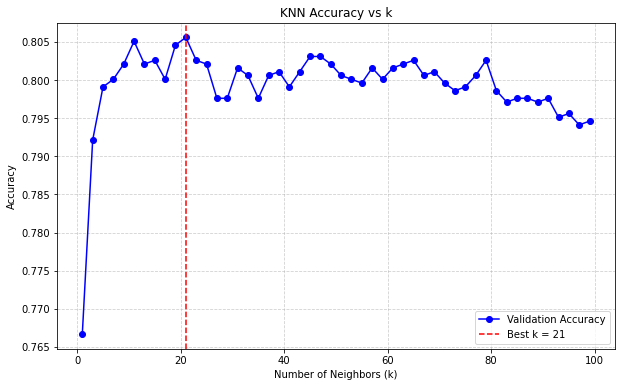

In [59]:
# 3. KNN Classifier (Manual Implementation)

from collections import Counter
from scipy.stats import mode
class KNN:
    def __init__(self, k=3):
        self.k = k

    def fit(self, X_train, y_train):
        self.X_train = np.array(X_train)
        self.y_train = np.array(y_train)

    def predict(self, X_validation):
        X_validation = np.array(X_validation)

        # Compute Euclidean distances (vectorized)
        distances = np.sqrt(
            np.sum((X_validation[:, np.newaxis, :] - self.X_train[np.newaxis, :, :]) ** 2, axis=2)
        )

        # Get indices of k nearest neighbors
        k_indices = np.argpartition(distances, self.k, axis=1)[:, :self.k]

        # Retrieve corresponding labels
        k_nearest_labels = self.y_train[k_indices]

        # Compute majority vote using np.unique
        predictions = []
        for labels in k_nearest_labels:
            unique_labels, counts = np.unique(labels, return_counts=True)
            predictions.append(unique_labels[np.argmax(counts)])

        return np.array(predictions)


# --- Prepare training and validation data ---
X_train = training_set.iloc[:, :-1].values
y_train = training_set[class_col].values

X_validation = validation_set.iloc[:, :-1].values
y_validation = validation_set[class_col].values

# --- Try different k values ---
k_values = range(1, 101, 2)
accuracies = []

for k in k_values:
    classifier = KNN(k=k)
    classifier.fit(X_train, y_train)
    
    predictions = classifier.predict(X_validation)
    accuracy = np.mean(predictions == y_validation)
    accuracies.append(accuracy)

# --- Best result ---
best_k = k_values[np.argmax(accuracies)]
print(f"Best k = {best_k}, Accuracy = {100 * max(accuracies):.4f}%")


# --- Plot Accuracy vs k ---
plt.figure(figsize=(10, 6))
plt.plot(k_values, accuracies, marker='o', linestyle='-', color='b', label='Validation Accuracy')
plt.axvline(best_k, color='r', linestyle='--', label=f'Best k = {best_k}')
plt.title("KNN Accuracy vs k")
plt.xlabel("Number of Neighbors (k)")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


# Discussion:
# - When k is very small (e.g., k = 1), the model tends to overfit:
#   it memorizes training data and is very sensitive to noise.
# - As k increases, the model becomes smoother and generalizes better.
# - However, if k is too large, the model may underfit:
#   it averages over too many points, losing important local patterns.
# - The best k usually balances both — giving high validation accuracy
#   without overfitting or underfitting.

Accuracy: 79.46%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.749400  0.904348  0.819615
1     h   0.869221  0.677652  0.761574

Confusion Matrix:


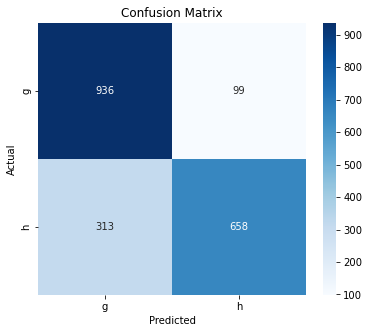

In [60]:
# Classification Evaluation Function

def evaluate_classification(y_target, y_predicted):
    # Convert inputs to NumPy arrays for consistency
    y_target = np.array(y_target)
    y_predicted = np.array(y_predicted)

    # Get all unique class labels
    classes = np.unique(np.concatenate((y_target, y_predicted)))

    # Initialize confusion matrix
    conf_matrix = np.zeros((len(classes), len(classes)), dtype=int)

    # Fill confusion matrix
    for i in range(len(y_target)):
        true_idx = np.where(classes == y_target[i])[0][0]
        pred_idx = np.where(classes == y_predicted[i])[0][0]
        conf_matrix[true_idx, pred_idx] += 1
    
    # Calculate per-class metrics
    precision, recall, f1 = [], [], []

    for i in range(len(classes)):
        TP = conf_matrix[i, i]
        FP = np.sum(conf_matrix[:, i]) - TP
        FN = np.sum(conf_matrix[i, :]) - TP

        prec = TP / (TP + FP) if (TP + FP) != 0 else 0
        rec = TP / (TP + FN) if (TP + FN) != 0 else 0
        f1_score = (2 * prec * rec) / (prec + rec) if (prec + rec) != 0 else 0

        precision.append(prec)
        recall.append(rec)
        f1.append(f1_score)

    # Compute overall accuracy
    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)

    # Combine metrics into a DataFrame
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    })

    return accuracy, metrics_df, conf_matrix


# Evaluate model performance on validation set
y_target = validation_set[class_col].to_numpy()
y_predicted = predictions

accuracy, metrics_df, conf_matrix = evaluate_classification(y_target, y_predicted)

# Display results
print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)

# Plot confusion matrix
print("\nConfusion Matrix:")
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [61]:
# Manual implementation final test
X_manual_test = test_set.iloc[:, :-1]
y_manual_test = test_set[class_col]

manual_test_prediction = classifier.predict(X_manual_test)

Accuracy: 79.72%

Per-class metrics:
  Class  Precision    Recall  F1-score
0     g   0.757225  0.890291  0.818385
1     h   0.858040  0.699079  0.770446

Confusion Matrix:


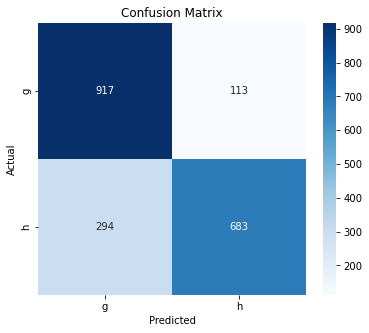

In [62]:

y_manual_test = y_manual_test.to_numpy()
accuracy, metrics_df, conf_matrix = evaluate_classification(y_manual_test,manual_test_prediction)

print(f"Accuracy: {accuracy * 100:.2f}%\n")
print("Per-class metrics:")
print(metrics_df)
print("\nConfusion Matrix:")
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=metrics_df['Class'],
            yticklabels=metrics_df['Class'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [63]:
# 4.KNN implementation using scikit-learn

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# Separate features and target
X = telescope_data.iloc[:, :-1]
Y = telescope_data[class_col]

# Step 1: Split into training + temp (which will later be split into validation and test)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, Y, test_size=0.3, random_state=0
)

# Step 2: Split the temp data into validation and test sets equally (15% each)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=0
)

clf = KNeighborsClassifier(n_neighbors=25)
clf.fit(X_train, y_train)

,n_neighbors,25
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [64]:
y_val_pred = clf.predict(X_val)
print("validation set predictions: {}".format(y_val_pred))

validation set predictions: ['h' 'g' 'g' ... 'g' 'h' 'g']


In [65]:
print("validation set accuracy: {:.2f}%".format(clf.score(X_val, y_val) * 100))

validation set accuracy: 80.36%


Validation Accuracy: 80.36%

Classification Report:
              precision    recall  f1-score   support

           g       0.76      0.89      0.82      1023
           h       0.86      0.72      0.78       983

    accuracy                           0.80      2006
   macro avg       0.81      0.80      0.80      2006
weighted avg       0.81      0.80      0.80      2006



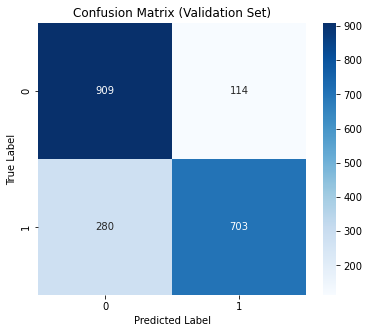

In [66]:
# classification evaluation with scikit-learn

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_val, y_val_pred))

# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [67]:
# Final test
test_prediction = clf.predict(X_test)

Validation Accuracy: 81.66%

Classification Report:
              precision    recall  f1-score   support

           g       0.77      0.90      0.83      1011
           h       0.88      0.73      0.80       996

    accuracy                           0.82      2007
   macro avg       0.83      0.82      0.82      2007
weighted avg       0.83      0.82      0.82      2007



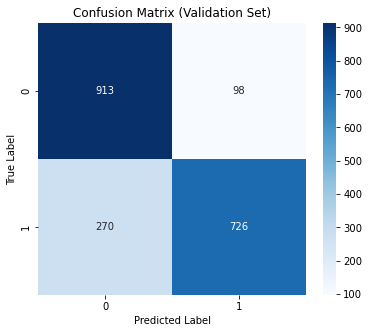

In [42]:
# classification evaluation with scikit-learn

accuracy = accuracy_score(y_test, test_prediction)
print(f"Validation Accuracy: {accuracy * 100:.2f}%\n")

print("Classification Report:")
print(classification_report(y_test, test_prediction))

# Confusion Matrix
conf_mat = confusion_matrix(y_test, test_prediction)

plt.figure(figsize=(6,5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix (Validation Set)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()